In [1]:
from gensim import models
import numpy as np

In [2]:
first_model = models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin\GoogleNews-vectors-negative300.bin', binary=True)

In [3]:
first_model.most_similar('man')

[('woman', 0.7664012908935547),
 ('boy', 0.6824871301651001),
 ('teenager', 0.6586930155754089),
 ('teenage_girl', 0.6147903203964233),
 ('girl', 0.5921714305877686),
 ('suspected_purse_snatcher', 0.571636438369751),
 ('robber', 0.5585119128227234),
 ('Robbery_suspect', 0.5584409832954407),
 ('teen_ager', 0.5549196600914001),
 ('men', 0.5489763021469116)]

On applique la même procédure du filtrage du modèle que celle de l'article 1. 

In [4]:
first_model.sort_by_descending_frequency()
first_model.unit_normalize_all()

In [5]:
first_model.index_to_key[:10]

['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with', 'said']

In [6]:
def verifier_chaine(chaine) :
    if chaine.islower() and chaine.isalpha() and len(chaine)<20 :
        return True
    return False

In [7]:
words_sorted = first_model.index_to_key[:50000]
words_sorted = [word for word in words_sorted if verifier_chaine(word)]
words_sorted[:10], len(words_sorted)

(['in', 'for', 'that', 'is', 'on', 'with', 'said', 'was', 'the', 'at'], 24065)

In [8]:
vector_size = first_model.vector_size
model = models.keyedvectors.KeyedVectors(vector_size, count=0)
for word in words_sorted :
    model[word] = first_model[word]

In [9]:
model.most_similar('man')

[('woman', 0.7664012908935547),
 ('boy', 0.6824870109558105),
 ('teenager', 0.6586930155754089),
 ('girl', 0.5921714305877686),
 ('robber', 0.5585119128227234),
 ('men', 0.5489763021469116),
 ('guy', 0.5420035719871521),
 ('person', 0.5342026352882385),
 ('gentleman', 0.5337990522384644),
 ('motorcyclist', 0.5336882472038269)]

Maintenant, on cherche à étudier la géométrie du genre et des biais dans le word embedding. 

**Etape 1 : Identifier le sous-espace associé au genre.**

L'utilisation du langage est "désordonnée" et par conséquent, les paires de mots individuelles ne se comportent pas toujours comme prévu. Par exemple, le mot "man" a plusieurs usages différents : il peut être utilisé comme une exclamation comme dans "oh man !" ou pour se référer à des personnes des deux genres, ou encore en tant que verbe, par exemple "man the station". 

Pour estimer le biais de manière plus robuste, nous allons agréger plusieurs comparaisons par paires. En combinant plusieurs directions, telles que (she-he) et (woman - man), nous identifions une direction de genre g ∈ R**d qui capture largement le genre dans l'incorporation (embedding).

In [10]:
#calculons les différences de vecteur pour toutes les paires similaires à she/he
vect_she = model['she']
vect_he = model['he']
diff1 = (vect_she-vect_he)/np.linalg.norm(vect_she-vect_he)

vect_her = model['her']
vect_his = model['his']
diff2 = (vect_her-vect_his)/np.linalg.norm(vect_her-vect_his)

vect_woman = model['woman']
vect_man = model['man']
diff3 = (vect_woman-vect_man)/np.linalg.norm(vect_woman-vect_man)

vect_herself = model['herself']
vect_himself = model['himself']
diff5 = vect_herself-vect_himself/np.linalg.norm(vect_herself-vect_himself) 

vect_daughter = model['daughter']
vect_son = model['son']
diff6 = (vect_daughter-vect_son)/np.linalg.norm(vect_daughter-vect_son)

vect_mother = model['mother']
vect_father = model['father']
diff7 = (vect_mother-vect_father)/np.linalg.norm(vect_mother-vect_father)

vect_gal = model['gal']
vect_guy = model['guy']
diff8 = (vect_gal-vect_guy)/np.linalg.norm(vect_gal-vect_guy)

vect_girl = model['girl']
vect_boy = model['boy']
diff9 = (vect_girl-vect_boy)/np.linalg.norm(vect_girl-vect_boy)

vect_female = model['female']
vect_male = model['male']
diff10 = (vect_female - vect_male)/np.linalg.norm(vect_female-vect_male)

#Rmq : dans l'article, font aussi la diff vectMary-vectJohn,
#BIZARRE : sont censés avoir enlevé les majuscules du vocabulaire

Pour identifier le sous-espace associé au genre, on regarde l'ACP des 10 vecteurs précédents associés au genre. 

In [11]:
#on fait un array qui contient toutes les différences de vecteurs
#il y a 10 individus et 300 dimensions pour chaque vecteur
DIFF = np.array([diff1, diff2, diff3, diff5, diff6, diff7, diff8, diff9, diff10])  
D = np.transpose(DIFF)
D.shape

(300, 9)

In [12]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=9)
pca.fit(D)

PCA(n_components=9)

Text(0, 0.5, 'Proportion de variance expliquée')

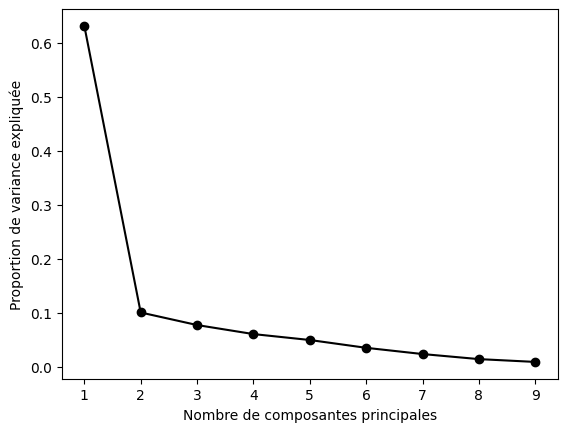

In [13]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1, 10), pca.explained_variance_ratio_, marker='o', color='black')
plt.xlabel("Nombre de composantes principales")
plt.ylabel("Proportion de variance expliquée")

In [14]:
#on affiche la première composante qui correspond à la direction de plus grande variance
#soit la direction qu'on associe au sous-espace de genre
pcs = pca.components_
dir_genre = np.dot(D, pcs[0])
print(dir_genre.shape)
print(np.linalg.norm(dir_genre))
dir_genre = dir_genre/np.linalg.norm(dir_genre)
print(np.linalg.norm(dir_genre))

(300,)
2.3657408
0.99999994


**Etape 2 : calcul du biais direct**

Pour mesurer le biais direct, nous identifions d'abord les mots qui devraient être neutres en termes de genre pour l'application en question. Comment générer cet ensemble de mots neutres en termes de genre est décrit dans la Section 7.
*Dans ce notebook, on ne vas pas gérer l'ensemble des mots neutres mais simplement évaluer la méthode sur les métiers possibles, qui sont par essence des mots neutres.*

Une fois les mots neutres en termes de genre, notés par $ N $, et la direction de genre apprise ci-dessus, $ g $, définis, nous définissons le biais de genre direct d'une incorporation comme suit :

$ DirectBias_c = \frac{1}{|N|} \sum_{w \in N} | \cos(\tilde{w}, g) |^c $

où $ c $ est un paramètre qui détermine à quel point nous voulons être stricts dans la mesure du biais. Si $ c $ est 0, alors $ | \cos(\tilde{w} - g) |^c = 0 $ seulement si $ \tilde{w} $ n'a aucun chevauchement avec $ g $ (donc si le genre n'a absolument aucune influence), sinon il est égal à 1. Un biais plus graduel serait d'attribuer c=1. *La présentation que nous avons choisie favorise la simplicité - il serait naturel d'étendre nos définitions pour pondérer les mots par fréquence.* --> **piste de recherche** 

OU TROUVER LA LISTE DES METIERS ? 

In [15]:
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel

In [29]:
metiers = [
    "doctor",
    "nurse",
    "lawyer",
    "teacher",
    "electrician",
    "plumber",
    "accountant",
    "secretary",
    "chef",
    "farmer",
    "artist",
    "musician",
    "actor",
    "journalist",
    "writer",
    "astronomer",
    "pharmacist",
    "veterinarian",
    "hairdresser",
    "esthetician",
    "pilot",
    "firefighter",
    "mechanic",
    "technician",
    "architect",
    "clerk",
    "guard",
    "coach",
    "referee",
    "driver",
    "baker",
    "carpenter",
    "tailor",
    "laborer",
    "cleaner",
    "waiter",
    "waitress",
    "bartender",
    "cashier",
    "butcher",
    "librarian",
    "receptionist",
    "janitor",
    "landscaper",
    "gardener",
    "stylist",
    "model",
    "photographer",
    "biologist",
    "chemist",
    "physicist",
    "geologist",
    "meteorologist",
    "oceanographer",
    "zoologist",
    "botanist",
    "ecologist",
    "psychologist",
    "counselor",
    "trainer",
    "advisor",
    "analyst",
    "planner",
    "consultant",
    "contractor",
    "agent",
    "broker",
    "seller",
    "buyer",
    "trader",
    "investor",
    "marketer",
    "promoter",
    "advertiser",
    "publisher",
    "printer",
    "designer",
    "illustrator",
    "animator",
    "programmer",
    "developer",
    "engineer",
    "technologist",
    "scientist",
    "researcher",
    "professor",
    "lecturer",
    "educator",
    "tutor",
    "instructor",
    "mentor",
    "creator",
    "owner",
    "partner",
    "chief",
    "president",
    "chairman",
    "CEO",
    "CTO",
    "CFO",
    "COO",
    "CIO",
    "vice",
    "assistant",
    "associate",
    "representative",
    "specialist",
    "expert",
    "professional",
    "practitioner",
    "pro",
    "guru",
    "wizard",
    "ninja",
    "administrator",
    "entrepreneur",
    "founder",
    "leader",
    "executive",
    "executive",
    "administrator",
    "manager"
]

In [34]:
vect_metiers = []
for metier in metiers :
    if metier in model :
        #attention, il faut normaliser les vecteurs
        vect = model[metier]/np.linalg.norm(model[metier])
        vect_metiers.append(vect)

In [35]:
print(len(metiers))
print(len(vect_metiers))

122
108


In [37]:
vect_met = np.array(vect_metiers)
print(vect_met.shape)
#vect_met est donc une matrice de 108 lignes (108 occupations) et 300 colonnes

(108, 300)


In [38]:
mat_1 = linear_kernel((dir_genre).reshape(1,-1), vect_met) 
print(mat_1.shape)
#me donne une ligne et 327 colonnes
#chaque colonne correspond à la cos_sim entre la dir_genre et le vecteur associé à l'occupation


(1, 108)


In [39]:
def biais_direct(N, dir_genre, c) :
    mat_1 = linear_kernel((dir_genre).reshape(1,-1), N)
    somme_absolue_cos = np.sum(np.abs(mat_1)**c, axis=1)
    biais_direct = somme_absolue_cos/(N.shape[0])
    return biais_direct 

In [41]:
print('le biais direct est de {}'.format(biais_direct(vect_met, dir_genre, 1)))

le biais direct est de [0.08130379]


Dans l'article, le biais direct obtenu pour les 327 métiers est de B = 0,08.

Maintenant, on passe à l'étude des biais indirects. 

Le sous-espace de genre $ g $ que nous avons identifié nous permet de quantifier la contribution de $ g $ aux similarités entre n'importe quelle paire de mots. Nous pouvons décomposer un vecteur de mot donné $ w $ appartenant à $ R^d $ comme $ w = w_g + w_\perp $, où $ w_g = (w \cdot g)g $ est la contribution du genre et $ w_\perp = w - w_g $. Notez que tous les vecteurs de mots sont normalisés pour avoir une longueur unitaire. Nous définissons la composante de genre à la similarité entre deux vecteurs de mots $ w $ et $ v $ comme
$ VOIR ARTICLE J ARRIVE PAS A COPIER$

L'intuition derrière cette métrique est la suivante : $ w_\perp \cdot v_\perp / (\|w_\perp\|^2 \|v_\perp\|^2) $ est le produit scalaire entre les deux vecteurs si nous projetons le sous-espace de genre et renormalisons les vecteurs pour avoir une longueur unitaire. La métrique quantifie combien ce produit scalaire change (en tant que fraction de la valeur initiale du produit scalaire) en raison de cette opération de suppression du sous-espace de genre. En raison du bruit dans les données, chaque vecteur a une composante non nulle $ w_\perp $ et $ \beta $ est bien défini. Notez que $ \beta(w, w) = 0 $, ce qui est raisonnable puisque la similarité d'un mot à lui-même ne devrait pas dépendre de la contribution du genre. Si $ w_g = 0 = v_g $, alors $ \beta(w, v) = 0 $; et si $ w_\perp = 0 = v_\perp $, alors $ \beta(w, v) = 1 $.


In [21]:
def biais_indirect(vect1, vect2, dir): 
    vect1_para = np.dot(vect1, dir)*dir
    vect1_perp = vect1 - vect1_para
    vect2_para = np.dot(vect2, dir)*dir
    vect2_perp = vect2 - vect2_para
    num_beta = np.dot(vect1_perp, vect2_perp)
    den_beta = (np.linalg.norm(vect1_perp)**2)*(np.linalg.norm(vect2_perp)**2)
    beta = (np.dot(vect1, vect2) - num_beta/den_beta) / np.dot(vect1, vect2)
    return beta  

In [22]:
mot_football = model['football']
mot_businessman = model['businessman']
mot_maestro = model['maestro']
mot_pundit = model['pundit']
mot_cleric = model['cleric']
print(biais_indirect(mot_football, mot_businessman, dir_genre))
print(biais_indirect(mot_football, mot_maestro, dir_genre))
print(biais_indirect(mot_football, mot_pundit, dir_genre))
print(biais_indirect(mot_football, mot_cleric, dir_genre))

0.15344360553987801
0.4311159891116291
0.07866272679416848
0.0015101342825190147


Dans l'article : \
football-businessman : 31%\
football-maestro : 42%\
football-pundit : 10%\
football-cleric : 2%

Les résultats sont à peu près cohérents, sauf pour businessman où le biais est de 31% dans l'article. 

In [27]:
mot_softball = model['softball']
mot_bookkeeper = model['bookkeeper']
mot_recetionist = model['receptionist']
#mot_registered_nurse = model['registered nurse']
#il n'y a pas registered nurse dans le vocabulaire de mon modèle --> PROBLEME
mot_waitress = model['waitress']
print("Le biais indirect entre {} et {} est {}.".format('softball', 'bookkeeper', biais_indirect(mot_softball, mot_bookkeeper, dir_genre)))
print("Le biais indirect entre {} et {} est {}.".format('softball', 'receptionist', biais_indirect(mot_softball, mot_recetionist, dir_genre)))
print("Le biais indirect entre {} et {} est {}.".format('softball', 'waitress', biais_indirect(mot_softball, mot_waitress, dir_genre)))
#print(biais_indirect(mot_softball, mot_bookkeeper, dir_genre))
#print(biais_indirect(mot_softball, mot_recetionist, dir_genre))
#print(biais_indirect(mot_softball, mot_waitress, dir_genre))

Le biais indirect entre softball et bookkeeper est 0.14789526819334717.
Le biais indirect entre softball et receptionist est 0.6422090835779127.
Le biais indirect entre softball et waitress est 0.2605798793145377.


Dans l'article : \
softball-bookkeeper : 20%\
softball-receptionniste : 67%\
softball-waitress : 35%